# Download CMAQ gridded-comparison

In [1]:
import requests
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
# programatically download CMAQ PM2.5 gridded estimates
years = list(range(2010,2021+1))
if not os.path.exists("CMAQ"):
    os.mkdir("CMAQ")
for year in years:
    print(year)
    if not os.path.exists(f"CMAQ/ds_input_cmaq_pm25_{year}.zip"):
        url = f"https://ofmpub.epa.gov/rsig/rsigserver?data/FAQSD/inputs/ds_input_cmaq_pm25_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"CMAQ/ds_input_cmaq_pm25_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)
        time.sleep(2)
    

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [3]:
year = 2010
cmaq2010 = pd.read_csv(f"CMAQ/ds_input_cmaq_pm25_{year}.zip")

In [4]:
display(cmaq2010.shape)
display(cmaq2010.columns)

(50092965, 7)

Index(['Domain', 'Col', 'Row', 'Lon', 'Lat', 'Date', 'Conc'], dtype='object')

In [5]:
display(len(np.unique(cmaq2010['Col'])))
display(459*109135)
display(len(np.unique(cmaq2010['Row'])))
display(299*167535)
display(50092965/137241)

459

50092965

299

50092965

365.0

In [6]:
import numpy as np

# make grouping matrix for CMAQ, 459 x 299 grid -> 92 x 60 (group squares 5x5, with 5x4 and 4x5 rects at the ends)
rows, cols = 459, 299
side_length = 5

group_matrix = np.zeros((rows, cols), dtype=int)

group_id = 1
for i in range(0, rows, side_length):
    for j in range(0, cols, side_length):
        group_matrix[i:i+side_length, j:j+side_length] = group_id
        group_id += 1

display(group_matrix)
flatGroup = group_matrix.flatten()
flatGroup.shape

array([[   1,    1,    1, ...,   60,   60,   60],
       [   1,    1,    1, ...,   60,   60,   60],
       [   1,    1,    1, ...,   60,   60,   60],
       ...,
       [5461, 5461, 5461, ..., 5520, 5520, 5520],
       [5461, 5461, 5461, ..., 5520, 5520, 5520],
       [5461, 5461, 5461, ..., 5520, 5520, 5520]])

(137241,)

In [7]:
groupCol = np.tile(flatGroup,365)

In [8]:
cmaq2010['group'] = groupCol

In [9]:
import geopandas as gpd

# Convert DataFrames to GeoDataFrames
def to_gdf(df, lat_col='latitude', lon_col='longitude'):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326")

In [10]:
# little subset to get a column of 10 5x5 squares, plus the next column to show they change
subset = list(range(0,50)) + list(range(299, 299+50)) + list(range(299*2, (299*2)+50)) + list(range(299*3, (299*3)+50)) + list(range(299*4, (299*4)+50))  + list(range(299*5, (299*5)+50))

In [11]:
# Parameters
square_size = 5  # 5x5 squares
squares_per_column = 10
num_columns = 15
row_stride = 299  # how many indices to skip to move down one row

# Generate subset
subset = []
for col in range(num_columns):
    start = col * row_stride
    subset.extend(range(start, start + square_size * squares_per_column))

# subset now contains 3 columns of 10 stacked 5x5 squares

In [12]:
cmaqDrop = cmaq2010.drop('Domain', axis=1).groupby(['group', 'Date']).mean()

In [13]:
cmaqDrop.shape

(2014800, 5)

In [46]:
cmaq2010geo = to_gdf(cmaq2010.iloc[subset], 'Lat', 'Lon')

In [47]:
cmaq2010geo.explore(column="group", categorical=True)

<Axes: >

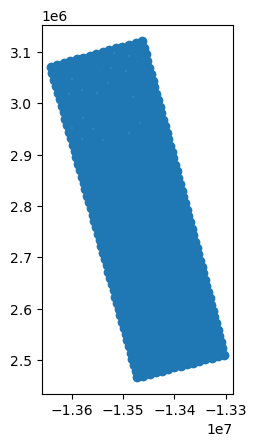

In [50]:
cmaq2010geo.to_crs(epsg=3857).plot()

In [ ]:
# programatically download both federally-regulated and non-federally-regulated daily PM2.5 information
# https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw
years = list(range(2010,2021+1))
if not os.path.exists("PM2.5"):
    os.mkdir("PM2.5")
for year in years:
    print(year)
    if not os.path.exists(f"PM2.5/daily_88101_{year}.zip"):
        url = f"https://aqs.epa.gov/aqsweb/airdata/daily_88101_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"PM2.5/daily_88101_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)

    if not os.path.exists(f"PM2.5/daily_88502_{year}.zip"):
        url = f"https://aqs.epa.gov/aqsweb/airdata/daily_88502_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"PM2.5/daily_88502_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)
        time.sleep(2)
    

In [ ]:
# download bulk meteostat data
if not os.path.exists("meteostat/bulk_data_full.json.gz"):
    url = "https://bulk.meteostat.net/v2/stations/full.json.gz"
    response = requests.get(url, stream=True)
    if not os.path.exists("meteostat"):
        os.mkdir("meteostat")
        with open("meteostat/bulk_data_full.json.gz", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)


In [ ]:
import json
import gzip

with gzip.open('meteostat/bulk_data_full.json.gz', 'r') as fin:
    full = json.loads(fin.read().decode('utf-8'))
usStations = [x for x in full if x["country"] == "US"]
usStations[0:3]

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# radius for matching
radius = 100

# Convert DataFrames to GeoDataFrames
def to_gdf(df, lat_col='latitude', lon_col='longitude'):
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# add geometry column for long/lat comparisons
PM2010geo = to_gdf(PM2010, 'Latitude', 'Longitude')
PM2010_88502geo = to_gdf(PM2010_88502, 'Latitude', 'Longitude')